In [1]:
import re
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from imutils import paths
from keras.callbacks import ModelCheckpoint, EarlyStopping
from numba import cuda
import tensorflow as tf
from keras import backend as k
cuda.select_device(0)

Using TensorFlow backend.


<weakproxy at 0x7f655d3f2278 to Device at 0x7f6601f73710>

In [2]:
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
print("[INFO] loading images...")
location = "/home/ravi/projects/gitex/face/images(copy)"
imagePaths = list(paths.list_images(location))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]
classNames

[INFO] loading images...


['Abdullah',
 'Adish',
 'Ajith',
 'Akash',
 'Alan',
 'Anees',
 'Anne',
 'Bala_Vignesh',
 'Bharath',
 'Deva',
 'Dhamu',
 'Dinesh',
 'Ganesh',
 'Gowtham',
 'Guru',
 'Hisrath',
 'Inzamam',
 'Jeevesh',
 'Kalyan',
 'Mohan',
 'Muthu',
 'Nitasha',
 'Nivash',
 'Pavan',
 'Pooja',
 'Praveen',
 'Prithivi',
 'Raja',
 'Rajesh',
 'Ramesh',
 'Ramya',
 'Ravi',
 'Savithri',
 'Sravani',
 'Surendher',
 'Vaishnavi',
 'Venky',
 'Vimal',
 'Vineeth',
 'Yadav']

In [4]:
images = list(paths.list_images(location+'/'+classNames[0]))
images

['/home/ravi/projects/gitex/face/images(copy)/Abdullah/228.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/116.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/180.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/136.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/220.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/172.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/168.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/164.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/148.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/128.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/80.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/144.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/152.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/264.jpg',
 '/home/ravi/projects/gitex/face/images(copy)/Abdullah/112.jpg',
 '/home/ravi/projects/gite

In [5]:
labels = {}
import cv2
def get_data(size, total_sample_size1, total_sample_size_2):
    count = 0
    dim1 = 64
    dim2 = 48
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size_1, 2, 1, dim2, dim1])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size_1, 1])
    
    for i in range(len(classNames)):
        images = list(paths.list_images(location+'/'+classNames[i]))
        temp = 1
        for j in range(len(images)-1):
            img1 = cv2.imread(images[j],0)
            img2 = cv2.imread(images[temp],0)
            img1 = cv2.resize(img1,(dim1,dim2),interpolation=cv2.INTER_AREA)
            img2 = cv2.resize(img2,(dim1,dim2),interpolation=cv2.INTER_AREA)
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            cv2.imshow('1',img1)
            cv2.imshow('2',img2)
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1
            temp +=1
            labels[count] = classNames[i]
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            #print(temp)
        print(count)
    cv2.destroyAllWindows()
    
    count = 0
    x_imposite_pair = np.zeros([total_sample_size_2, 2, 1, dim2, dim1])
    y_imposite = np.zeros([total_sample_size_2, 1])
    
    for i in range(len(classNames)):
        images = list(paths.list_images(location+'/'+classNames[i]))
        rand_images = np.random.randint(len(images),size = 80)
        other_images = list(set(paths.list_images(location))-set(images))
        rand_other_images = np.random.randint(len(other_images),size = 80)
        temp = 1
        for j in range(80):
            img1 = cv2.imread(images[rand_images[j]],0)
            img2 = cv2.imread(other_images[rand_other_images[j]],0)
            img1 = cv2.resize(img1,(dim1,dim2),interpolation=cv2.INTER_AREA)
            img2 = cv2.resize(img2,(dim1,dim2),interpolation=cv2.INTER_AREA)
            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            cv2.imshow('3',img1)
            cv2.imshow('4',img2)
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_imposite[count] = 0
            count += 1
            temp +=1
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            #print(temp)
        print(count)
    cv2.destroyAllWindows()
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y


In [6]:
len(labels)

0

In [7]:
size = 2
total_sample_size_1 = 2254
total_sample_size_2 = 3200
X,Y = get_data(size, total_sample_size_1,total_sample_size_2)

69
138
207
276
283
352
421
425
496
565
634
703
772
841
910
979
1048
1117
1186
1255
1324
1328
1397
1401
1470
1539
1608
1677
1746
1815
1887
1897
1966
1970
2039
2108
2112
2181
2185
2254
80
160
240
320
400
480
560
640
720
800
880
960
1040
1120
1200
1280
1360
1440
1520
1600
1680
1760
1840
1920
2000
2080
2160
2240
2320
2400
2480
2560
2640
2720
2800
2880
2960
3040
3120
3200


In [8]:
Y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [9]:
X.shape

(5454, 2, 1, 48, 64)

In [10]:
Y.shape

(5454, 1)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [12]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq


In [13]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [14]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

Instructions for updating:
Colocations handled automatically by placer.


/home/ravi/landt/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), input_shape=(1, 48, 64..., padding="valid", data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/ravi/landt/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (3, 3), padding="valid", data_format="channels_first")`
/home/ravi/landt/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


In [15]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [16]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [17]:
epochs = 30
rms = RMSprop()

In [18]:
model = Model(input=[img_a, img_b], output=distance)

/home/ravi/landt/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  """Entry point for launching an IPython kernel.


In [19]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [20]:
model.compile(loss=contrastive_loss, optimizer=rms)

In [21]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [22]:
x_train[0,1].shape

(1, 48, 64)

In [23]:
#earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#mcp_save = ModelCheckpoint('.best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=128, verbose=2, nb_epoch=epochs)

Instructions for updating:
Use tf.cast instead.


/home/ravi/landt/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 3067 samples, validate on 1023 samples
Epoch 1/30
 - 2s - loss: 0.2883 - val_loss: 0.2565
Epoch 2/30
 - 0s - loss: 0.1728 - val_loss: 0.1994
Epoch 3/30
 - 0s - loss: 0.1345 - val_loss: 0.1544
Epoch 4/30
 - 0s - loss: 0.1135 - val_loss: 0.1166
Epoch 5/30
 - 0s - loss: 0.1015 - val_loss: 0.1162
Epoch 6/30
 - 0s - loss: 0.0896 - val_loss: 0.0992
Epoch 7/30
 - 0s - loss: 0.0827 - val_loss: 0.0978
Epoch 8/30
 - 0s - loss: 0.0741 - val_loss: 0.1006
Epoch 9/30
 - 0s - loss: 0.0746 - val_loss: 0.0956
Epoch 10/30
 - 0s - loss: 0.0685 - val_loss: 0.1359
Epoch 11/30
 - 0s - loss: 0.0675 - val_loss: 0.1087
Epoch 12/30
 - 0s - loss: 0.0634 - val_loss: 0.0967
Epoch 13/30
 - 0s - loss: 0.0608 - val_loss: 0.0783
Epoch 14/30
 - 0s - loss: 0.0600 - val_loss: 0.0883
Epoch 15/30
 - 0s - loss: 0.0580 - val_loss: 0.0749
Epoch 16/30
 - 0s - loss: 0.0574 - val_loss: 0.0825
Epoch 17/30
 - 0s - loss: 0.0558 - val_loss: 0.0628
Epoch 18/30
 - 0s - loss: 0.0530 - val_loss: 0.0573
Epoch 19/30
 - 0s - loss:

In [24]:
pred = model.predict([x_test[:,0], x_test[:,1]])

In [25]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [26]:
compute_accuracy(pred, y_test)

0.904610492845787

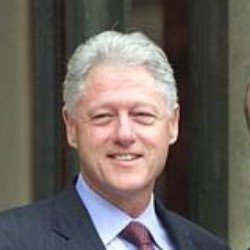

In [27]:
Image.open('/home/ravi/projects/gitex/FaceRec/images/Bill_Clinton/Bill_Clinton_0005.jpg')

In [28]:
x_train[10].shape

(2, 1, 48, 64)

In [29]:
dim1 = 64
dim2 = 48
img1 = cv2.imread('/home/ravi/projects/gitex/FaceRec/test/1276683_10151812542555956_1766883197_o.jpg',0)
img2 = cv2.imread('/home/ravi/projects/gitex/FaceRec/images/Alan/20190906_153855.jpg',0)
img1 = cv2.resize(img1,(dim1,dim2),interpolation=cv2.INTER_AREA)
img2 = cv2.resize(img2,(dim1,dim2),interpolation=cv2.INTER_AREA)

In [30]:
x_test_pair = np.zeros([1, 2, 1, dim2, dim1])
x_test_pair[0, 0, 0, :, :]= img1/255
x_test_pair[0, 1, 0, :, :] = img2/255

In [31]:
pred = model.predict([x_test_pair[:,0], x_test_pair[:,1]])
pred[0][0]

0.50836885

In [32]:
genuine = X[:2254]

In [ ]:
prediction = model.predict([x_test_pair[:,1], genuine[:,0]])

In [ ]:
prediction = model.predict([test, genuine[:,0]])

In [ ]:
x_test_pair[:,1].shape

In [ ]:
genuine[:,0].shape

In [ ]:
x_test_pair[:,1]

In [1]:
test  = np.broadcast_to(x_test_pair[:,1], genuine[:,0].shape)

NameError: name 'np' is not defined

In [ ]:
prediction

In [ ]:
minElement = np.amin(prediction)
print('Printing min Element',minElement)
e =  np.where(prediction == np.amin(prediction))
e

In [ ]:
labels[e[0][0]]

In [33]:
from align_custom import AlignCustom
from face_feature import FaceFeature
aligner = AlignCustom();
from mtcnn_detect import MTCNNDetect
from tf_graph import FaceRecGraph
import tensorflow as tf
from keras import backend as k

MTCNNGraph = FaceRecGraph();
face_detect = MTCNNDetect(MTCNNGraph, scale_factor=1);
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

Loading MTCNN Face detection model
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
MTCNN Model loaded


In [34]:
vs = cv2.VideoCapture(0); #get input from webcam
dim1 = 64
dim2 = 48
import time
fps = 0
while True:
    _,frame = vs.read();
    start_time = time.time()
    #u can certainly add a roi here but for the sake of a demo i'll just leave it as simple as this
    rects, landmarks = face_detect.detect_face(frame,10);#min face size is set to 80x80
    aligns = []
    positions = []
    new_rect = []

    for (i, rect) in enumerate(rects):
        aligned_face, face_pos = aligner.align(160,frame,landmarks[:,i])
        img = cv2.resize(aligned_face,(dim1,dim2),interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        test_img = np.zeros([1, 2, 1, dim2, dim1])
        test_img[0, 0, 0, :, :]= img/255
        test  = np.broadcast_to(test_img[:,0], genuine[:,0].shape)
        print(test.shape)
        print(genuine[:,0].shape)
        prediction = model.predict([test, genuine[:,0]])
        minElement = np.amin(prediction)
        print('Printing min Element',minElement)
        e =  np.where(prediction == np.amin(prediction))
        print('min element:', minElement)
        print(labels[e[0][0]])
        cv2.rectangle(frame,(rect[0],rect[1]),(rect[2],rect[3]),(255,0,0)) #draw bounding box for the face
        cv2.putText(frame,str(labels[e[0][0]]),(rect[0],rect[1]),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),1,cv2.LINE_AA)

    fps = (fps + (1. / (time.time() - start_time))) / 2
    cv2.putText(frame, 'fps : %s' % (str(round(fps, 2))), (150, 20), 0, 5e-3 * 150,(255, 255, 255), 2)
    cv2.imshow("Frame",frame)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
cv2.destroyAllWindows()

(2254, 1, 48, 64)
(2254, 1, 48, 64)


FailedPreconditionError: Attempting to use uninitialized value dense_2/bias
	 [[{{node dense_2/bias/read}}]]
	 [[{{node lambda_1/Sqrt}}]]

In [ ]:
cv2.destroyAllWindows()

In [ ]:
genuine[:,0].shape

In [ ]:
print(os.path.abspath('1.py'))

In [ ]:
labels